[View in Colaboratory](https://colab.research.google.com/github/raoulbia/ipython/blob/master/induced_voltages.ipynb)

# **Graphs: Vertex Voltages**

One can model graphs as resistor networks where edges are resistors connecting vertices and voltages are applied at the vertices. 

This model allows to infer voltage values (and thus also current flow) at all vertices from known values at a few vertices. Specifically, subject to fixing s=1V and t=0V, the voltages at every node will minimize:

<br>
<p align="center">$\sum _{(a,b) \in E)} = (v(a) - v(b))^2 $   &nbsp;&nbsp;&nbsp;(Equation 1)
<br>

In [0]:
import collections
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix # csr = Compressed Sparse Row matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import scipy.optimize as opt

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

**Construct directed graph** as per Figure 3 in *Faloutsos et al., 2006*

In [0]:
G = nx.DiGraph()
G.add_edge('s','a')
G.add_edge('s','b')
G.add_edge('a','c')
G.add_edge('a','b')
G.add_edge('b','c')
G.add_edge('b','t')
G.add_edge('c','t')

**Show graph** (as seen in Figure 3 of the paper)

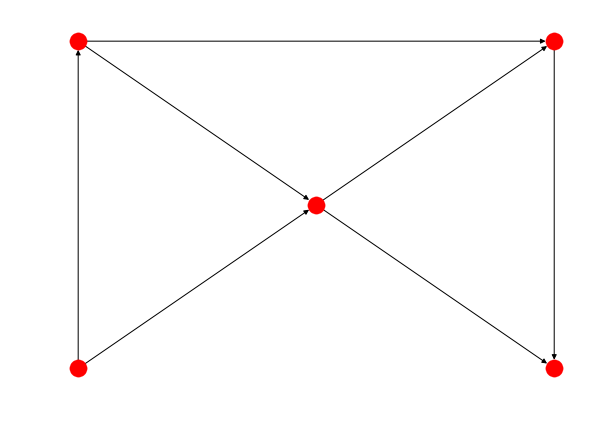

In [4]:
fixed_positions = {'s':(0,0), 'a':(0,2), 'b':(1,1), 'c':(2,2), 't':(2,0)}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)
nx.draw(G, pos)
plt.show()

**Objective Function** to minimize Equation 1 above:

In [0]:
def objective(x, edges, node_pos_dict):
    goodness_score = 0
    for i in range(len(edges)):
        if edges[i][0] == 's':
            goodness_score += (1 - x[node_pos_dict.get(edges[i][1])]) ** 2
        elif edges[i][1] == 't':
            goodness_score += (x[node_pos_dict.get(edges[i][0])] - 0) ** 2
        else:
            goodness_score += (x[node_pos_dict.get(edges[i][0])] - x[node_pos_dict.get(edges[i][1])]) ** 2
    return goodness_score

**Get voltages**

In [6]:
edges = list(G.edges())
nodes = list(G.nodes())
n = len(nodes)
e = len(edges)

x = [1, 0, 0, 0, 0]                                                     # initial guess solution array w/hardcoded s and t
node_position_dict = {}                                                 # helper Dict to enable dynamic construction of objective function

# map each node to its position in the solution array
for i in range(n):                                                      
    node_position_dict[nodes[i]] =  int(i)

# call to objective function
result = opt.minimize(objective, x, args=(edges, node_position_dict))
res = np.round(result.x, 3)
print("Induced Voltages: ", res)                      

Induced Voltages:  [1.000 0.625 0.500 0.375 0.000]


**Compute Adjaceny Matrix of Currents**

This matrix will be useful in the next stage when we need to (conveniently) get the sum of outgoing currents for each of the vertices on a path from `s` to `t`.

In [17]:
# get the adjacency matrix for G
A = nx.to_scipy_sparse_matrix(G, nodelist=['s', 'a', 'b', 'c', 't'])
A = A.todense()
A = A * 1.0 # to allow decimal values in matrix A


# map each node to its voltage
node_volt_dict = {}
for i in range(n):                                                      
    node_volt_dict[nodes[i]] =  res[i] # `res` is the array of node voltages [1.000 0.625 0.500 0.375 0.000]

print('Node Voltage Dictionary:', node_volt_dict)
print('Directed Edges in G: ', edges)
print('Node Position Dictionary', node_position_dict)

# print(A)
for i in range(n):
  for j in range(n): 
   if A[i,j] == 1:
      A[i,j] = node_volt_dict[list(node_volt_dict)[i]] - node_volt_dict[list(node_volt_dict)[j]] # `list(node_volt_dict)[i]` is used for indexing into the Dict (not pythonic....)
print('\nAdjacency Matrix of currents:\n\n', A)

               

Node Voltage Dictionary: {'s': 1.0, 'a': 0.625, 'b': 0.5, 'c': 0.375, 't': 0.0}
Directed Edges in G:  [('s', 'a'), ('s', 'b'), ('a', 'c'), ('a', 'b'), ('b', 'c'), ('b', 't'), ('c', 't')]
Node Position Dictionary {'s': 0, 'a': 1, 'b': 2, 'c': 3, 't': 4}

Adjacency Matrix of currents:

 [[0.000 0.375 0.500 0.000 0.000]
 [0.000 0.000 0.125 0.250 0.000]
 [0.000 0.000 0.000 0.125 0.500]
 [0.000 0.000 0.000 0.000 0.375]
 [0.000 0.000 0.000 0.000 0.000]]


**Compute Delivered Current**

This section computes the delivered current for all paths connecting `s` and `t`.

* The current delivered by a given path is computed by taking into account the fact that vertics on the path may be connected to more than one neighbour thus distributing the current among its neighbours. The authors propose to take this "loss" of current into account by pro-rating the current delivered by a vertex proportionally to its total outgoing current.

As per paper, two definitions apply:

* For the starting edge in the path leaving `s`:

$$\hat{I}(s,u) = I(s,u)$$ 

* For all other edges:
          
$$\hat{I}(s, ..., u_i) = \hat{I}(s, ..., u_{i-1}) \frac{I(u_{i-1}, u_i)}{I_{out}(u_{i-1})}$$ 

In practice we can implement the above formulas as shown in the example below:

Path = (s -> a -> b -> c -> t)

Delivered current  = $I(s,a) \cdot \frac{I(a,b)}{I_{out}(a)} \cdot \frac{I(b,c)}{I_{out}(b)} \cdot \frac{I(c,t)}{I_{out}(c)}$


In [78]:
paths = []
delivered_current = 0
[paths.append(p) for p in nx.all_simple_paths(G,source='s',target='t')]
# print(paths)
for path in paths:
  for i in range(len(path)-1):
      k = node_position_dict[path[i]]
      v = node_position_dict[path[i+1]]
      if node_position_dict[path[i]] == 0:                      
  #       print(path[i], path[i+1], A[k,v])
        delivered_current = A[k,v]
      else:
  #       print(path[i], path[i+1], A[k,v], np.sum(A[k,:]))
        delivered_current *= (A[k,v] / np.sum(A[k,:]))
  print('Delivered Current for path %s: %s' % (path, round(delivered_current, 3)))
print('\n The above results match the results shown in the paper!')  

Delivered Current for path ['s', 'a', 'c', 't']: 0.25
Delivered Current for path ['s', 'a', 'b', 'c', 't']: 0.025
Delivered Current for path ['s', 'a', 'b', 't']: 0.1
Delivered Current for path ['s', 'b', 'c', 't']: 0.1
Delivered Current for path ['s', 'b', 't']: 0.4

 The above results match the results shown in the paper!


**Reference**:


Christos Faloutsos, Kevin S. McCurley, and Andrew Tomkins. 2004. Fast discovery of
connection subgraphs. In Proceedings of the tenth ACM SIGKDD international
conference on Knowledge discovery and data mining, pages 118{127. ACM.

**Useful links**:

http://cs-www.cs.yale.edu/homes/spielman/TALKS/blyth1.pdf (page 21)

https://www.stat.berkeley.edu/~mmahoney/s15-stat260-cs294/Lectures/lecture16-17mar15.pdf (page 1)

http://cs-www.cs.yale.edu/homes/spielman/TALKS/blyth1.pdf